# TSP con entregas consistentes

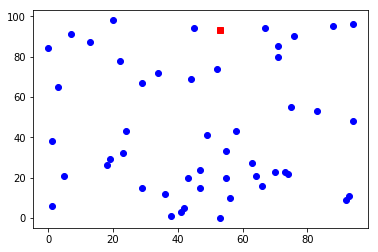

miramos subtours
miramos subtours
miramos subtours
miramos subtours
miramos subtours
miramos consistencia
maximo= 392 kk= 12 pp= 0 qq= 1 lengthpp= 14 lengthqq= 406
miramos subtours
miramos consistencia
maximo= 361 kk= 13 pp= 0 qq= 3 lengthpp= 380 lengthqq= 19
miramos subtours
miramos consistencia
maximo= 392 kk= 12 pp= 1 qq= 2 lengthpp= 406 lengthqq= 14
miramos subtours
miramos consistencia
maximo= 70 kk= 45 pp= 0 qq= 3 lengthpp= 223 lengthqq= 153
miramos subtours
miramos consistencia
maximo= 304 kk= 21 pp= 0 qq= 3 lengthpp= 363 lengthqq= 59
miramos subtours
miramos consistencia
maximo= 74 kk= 40 pp= 0 qq= 1 lengthpp= 120 lengthqq= 194
miramos subtours
miramos consistencia
maximo= 62 kk= 19 pp= 1 qq= 3 lengthpp= 310 lengthqq= 248
miramos subtours
miramos consistencia
maximo=

In [ ]:
m = 4   # number of days
n = 50  # number of locations
L = 30 # maximum difference for consistency
EPS = 0.001

days      = range(m)
locations = range(n)
customers = range(1,n)

import random
random.seed(12345)
points = [(random.randint(0,100),random.randint(0,100)) for i in range(n)]

V = {}
D = {}
for i in customers: D[i] = []
for d in days:
    V[d] = random.sample(customers,20)
    for i in V[d]: D[i].append(d)
    V[d].append(0)
     
import math
def distance(points, i, j):
    dx = points[i][0] - points[j][0]
    dy = points[i][1] - points[j][1]
    return math.floor(math.sqrt(dx*dx + dy*dy))

dist = {(i,j) : distance(points,i,j) for i in locations for j in locations if i!=j}

import matplotlib.pyplot as plt
def dibuja(selected):                #dibuja una ruta dada como una lista de arcos
    plt.plot([p[0] for p in points], [p[1] for p in points], 'bo')
    plt.plot( points[0][0] , points[0][1] , 'rs')
    for (i,j) in selected:
        plt.plot([points[i][0],points[j][0]], [points[i][1],points[j][1]], 'g-')
    plt.show()
        
dibuja({})
from gurobipy import *

modelo = Model()
x = tupledict()
for d in days:
    for i in V[d]:
        for j in V[d]:
            if i!=j :
                x[i,j,d] = modelo.addVar(obj=dist[i,j], vtype=GRB.BINARY, name='a[%d,%d,%d]'%(i,j,d))
f = tupledict()

import networkx as nx
                
def SEC():
    print("miramos subtours")
    corte = False
    vals = modelo.getAttr('x', x)
    for d in days:
        G = nx.Graph()
        G.add_edges_from( (i,j) for i in V[d] for j in V[d] if i!=j and vals[i,j,d]>EPS )
        Components = list(nx.connected_components(G))
        if len(Components) > 1:
            for S in Components:
                modelo.addConstr( quicksum( x[i,j,d] for i in S for j in S if i!=j ) <= len(S)-1 )
                corte = True
    return corte  


def Consistency():
    print( "miramos consistencia")
    vals = modelo.getAttr('x', x)
    length = {}
    for d in days:
        G = nx.DiGraph()
        G.add_weighted_edges_from( (i,j,dist[i,j]) for i in V[d] for j in V[d] if i!=j and vals[i,j,d]>EPS )
        for i in V[d]:
            length[i,d] = nx.dijkstra_path_length(G,source=0,target=i)
        G.clear()
    maximo = 0
    for i in customers:
        for p in D[i]:
            for q in D[i]:
                if p<q and maximo < abs(length[i,p]-length[i,q])  :
                    maximo = abs(length[i,p]-length[i,q])
                    kk = i
                    pp = p
                    qq = q
    print( "maximo=",maximo , "kk=",kk,"pp=",pp,"qq=",qq, "lengthpp=",length[kk,pp],"lengthqq=",length[kk,qq])
    if maximo <= L :
        return False

      
    for i in V[pp]:
        for j in V[pp]:
            if i!=j:
                f[i,j,kk,pp] = modelo.addVar(obj=0, vtype=GRB.BINARY, name='f[%d,%d,%d,%d]'%(i,j,kk,pp))
    for i in V[qq]:
        for j in V[qq]:
            if i!=j:
                f[i,j,kk,qq] = modelo.addVar(obj=0, vtype=GRB.BINARY, name='f[%d,%d,%d,%d]'%(i,j,kk,qq))
        
    modelo.addConstr(sum(f[0,j,kk,pp] for j in V[pp] if j!=0 ) == 1)
    modelo.addConstr(sum(f[j,0,kk,pp] for j in V[pp] if j!=0 ) == 0)
    modelo.addConstrs(sum(f[j,i,kk,pp]-f[i,j,kk,pp] for j in V[pp] if j!=i) == 0 for i in V[pp] if i!=kk and i!=0 )
    modelo.addConstrs( f[i,j,kk,pp] <= x[i,j,pp] for i in V[pp] for j in V[pp] if i!=j )

    modelo.addConstr(sum(f[0,j,kk,qq] for j in V[qq] if j!=0 ) == 1)
    modelo.addConstr(sum(f[j,0,kk,qq] for j in V[qq] if j!=0 ) == 0)
    modelo.addConstrs(sum(f[j,i,kk,qq]-f[i,j,kk,qq] for j in V[qq] if j!=i) == 0 for i in V[qq] if i!=kk and i!=0 )
    modelo.addConstrs( f[i,j,kk,qq] <= x[i,j,qq] for i in V[qq] for j in V[qq] if i!=j )
     
    modelo.addConstr( sum(dist[i,j]*f[i,j,kk,pp] for i in V[pp] for j in V[pp] if i!=j ) - sum(dist[i,j]*f[i,j,kk,qq] for i in V[qq] for j in V[qq] if i!=j ) <= L)
    modelo.addConstr( sum(dist[i,j]*f[i,j,kk,pp] for i in V[pp] for j in V[pp] if i!=j ) - sum(dist[i,j]*f[i,j,kk,qq] for i in V[qq] for j in V[qq] if i!=j ) >= -L)

    return True


def CATSPsec():
    modelo.addConstrs(sum(x[i,j,k] for j in V[k] if j!=i) == 1 for k in days for i in V[k] )
    modelo.addConstrs(sum(x[j,i,k] for j in V[k] if j!=i) == 1 for k in days for i in V[k] )

    modelo.Params.OutputFlag = 0

    modelo.optimize()
    while SEC() or Consistency():
        modelo.optimize()    
        
    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x)
    selected = [(i,j,k) for i,j,k in vals.keys() if vals[i,j,k] > EPS]
    print('Optimal path: %s' % str(selected))
    for k in days: 
        selected = []
        for i in V[k]:
            for j in V[k]:
                if i!=j and vals[i,j,k]>EPS:
                    selected.append( (i,j) )
        plt.subplot(2, 2, k+1)
        dibuja(selected)
        
CATSPsec()